In [2]:
# Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import scipy.stats as ss
from matplotlib import pyplot as plt

In [3]:
# Set up the failure mode class
from pof.failure_mode import FailureMode

fm = FailureMode(alpha=50, beta=1.5, gamma=10)

SyntaxError: invalid syntax (failure_mode.py, line 227)

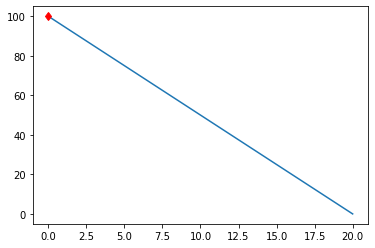

In [13]:
fm.condition.set_condition_profile()
fm.condition.plot_condition_profile()

In [14]:
for x in range(0,50):
    fm.sim(1)

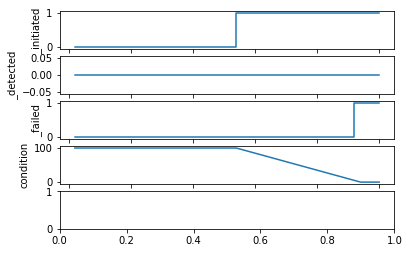

In [15]:
fm.sim_history()

In [20]:
fm.get_expected_condition(0,10)

True

In [23]:
fm.sim_initiation(10)

In [26]:
import scipy.stats as ss
impo

In [46]:
events = dict(
    wall_thickness = np.arange(0,20)
    )

In [44]:
# trigger type = 'time', 'condition', 'state'

triggers=dict(
    wall_thickness = dict(
        threshold_lower = 0,
        threshold_upper = 50,
    ),

    detected = True
)

In [49]:
detect = np.full(10,0)

for trigger in triggers:
    det = events[trigger]


In [45]:
threshold_upper = 15
threshold_lower = 5

det[det < threshold_upper] = 1
det[det > threshold_lower] = 1
det

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [47]:
events['wall_thickness'].where()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [69]:
task_criteria = (det > threshold_lower) & (det < threshold_upper)


In [70]:
task_criteria

array([False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False])